<a href="https://colab.research.google.com/github/LOOKatKimhyein/CRM-analysis/blob/main/(1)%EA%B3%A0%EA%B0%9D%EC%84%B8%EB%B6%84%ED%99%94_%EC%9D%B4%EC%83%81%EC%B9%98%EC%A0%9C%EA%B1%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### RFM (Recency, Frequency, Monetary)  
- 고객별 최근 구매시기, 구매횟수, 구매금액 기준으로 고객세분화를 진행

In [ ]:
# 분석에 필요한 library 호출 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [ ]:
df_org = pd.read_csv('./data.csv', encoding= 'latin') 
df_org.head() #데이터 확인 

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


#### invoiceDate변수 날짜형으로 변환

In [ ]:
df_org['InvoiceDate'] = pd.DatetimeIndex(df_org['InvoiceDate'])

In [ ]:
df_org['InvoiceDate']

0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
541904   2011-12-09 12:50:00
541905   2011-12-09 12:50:00
541906   2011-12-09 12:50:00
541907   2011-12-09 12:50:00
541908   2011-12-09 12:50:00
Name: InvoiceDate, Length: 541909, dtype: datetime64[ns]

In [ ]:
df_org['InvoiceDate2'] = df_org['InvoiceDate'].apply(lambda x : str(x)[:10])

In [ ]:
df_org.isna().sum()

InvoiceNo            0
StockCode            0
Description       1454
Quantity             0
InvoiceDate          0
UnitPrice            0
CustomerID      135080
Country              0
InvoiceDate2         0
dtype: int64

In [ ]:
df_org.shape

(541909, 9)

#### Customer na값 삭제(w.고객기준으로 계산할거니까)

In [ ]:
df_na_treat = df_org[~df_org['CustomerID'].isna()].reset_index(drop=True)

In [ ]:
df_na_treat.shape

(406829, 9)

In [ ]:
df_na_treat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406829 entries, 0 to 406828
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     406829 non-null  object        
 1   StockCode     406829 non-null  object        
 2   Description   406829 non-null  object        
 3   Quantity      406829 non-null  int64         
 4   InvoiceDate   406829 non-null  datetime64[ns]
 5   UnitPrice     406829 non-null  float64       
 6   CustomerID    406829 non-null  float64       
 7   Country       406829 non-null  object        
 8   InvoiceDate2  406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 27.9+ MB


### RFM에 필요한 변수 확인 및 이상치 확인

##### [필요한 변수]  
- R : today날짜와 invoiceDate2의 gap  
- F : CustomerID별  StockCode의 갯수(중복제거x < 이건 분석가 선택)  
- M : CustomerID, Stockcode 별 Quantity * UnitPrice구해서 더하기

In [ ]:
df_na_treat.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


#### 의심할만한 부분  
1) Quantity < 0 인 케이스  
2) Unitprice=0인 케이스  
3) Quantity가 80995건인 케이스(지나치게 많은 케이스)

In [ ]:
# 1) Quantity < 0 인 케이스  
minus_quantity = df_na_treat[df_na_treat.Quantity < 0]['CustomerID']

In [ ]:
len(minus_quantity)

8905

In [ ]:
df_na_treat[df_na_treat.CustomerID.isin(minus_quantity)].sort_values(by = 'CustomerID').tail(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate2
292511,570859,84879,ASSORTED COLOUR BIRD ORNAMENT,8,2011-10-12 15:22:00,1.69,18277.0,United Kingdom,2011-10-12
292510,570859,23323,WHITE WICKER STAR,6,2011-10-12 15:22:00,2.10,18277.0,United Kingdom,2011-10-12
292509,570859,22465,HANGING METAL STAR LANTERN,12,2011-10-12 15:22:00,1.65,18277.0,United Kingdom,2011-10-12
292505,570859,15056P,EDWARDIAN PARASOL PINK,3,2011-10-12 15:22:00,5.95,18277.0,United Kingdom,2011-10-12
292508,570859,20724,RED RETROSPOT CHARLOTTE BAG,10,2011-10-12 15:22:00,0.85,18277.0,United Kingdom,2011-10-12
292506,570859,20679,EDWARDIAN PARASOL RED,3,2011-10-12 15:22:00,5.95,18277.0,United Kingdom,2011-10-12
43154,C542086,22423,REGENCY CAKESTAND 3 TIER,-1,2011-01-25 12:34:00,12.75,18277.0,United Kingdom,2011-01-25
209684,562525,23295,SET OF 12 MINI LOAF BAKING CASES,8,2011-08-05 13:35:00,0.83,18282.0,United Kingdom,2011-08-05
209683,562525,23187,FRENCH STYLE STORAGE JAR BONBONS,48,2011-08-05 13:35:00,0.29,18282.0,United Kingdom,2011-08-05
209682,562525,21270,ANTIQUE CREAM CUTLERY CUPBOARD,1,2011-08-05 13:35:00,12.75,18282.0,United Kingdom,2011-08-05


In [ ]:
df_na_treat.shape

(406829, 9)

In [ ]:
#### 환불, 취소건은 제외
df_na_treat = df_na_treat[df_na_treat.Quantity > 0]

In [ ]:
df_na_treat.shape[0] + len(minus_quantity)

406829

In [ ]:
df_na_treat.shape

(397924, 9)

In [ ]:
# 2) Unitprice=0인 케이스  
df_na_treat[df_na_treat.UnitPrice ==0]
# 이건 사은품 정도로 생각하고 제외시키기

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate2
7012,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany,2010-12-05
23071,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom,2010-12-16
26046,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE,2010-12-21
29881,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,2011-01-06
29883,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,2011-01-06
35460,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2011-01-13 15:10:00,0.0,15107.0,United Kingdom,2011-01-13
55279,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10 13:08:00,0.0,17560.0,United Kingdom,2011-02-10
87903,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2011-03-23 10:25:00,0.0,13239.0,United Kingdom,2011-03-23
95201,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2011-03-30 12:45:00,0.0,13113.0,United Kingdom,2011-03-30
99945,548871,22162,HEART GARLAND RUSTIC PADDED,2,2011-04-04 14:42:00,0.0,14410.0,United Kingdom,2011-04-04


In [ ]:
df_na_treat[df_na_treat.UnitPrice ==0].shape

(40, 9)

In [ ]:
397924-40

397884

In [ ]:
df_na_treat = df_na_treat[df_na_treat.UnitPrice > 0].reset_index(drop=True)

In [ ]:
df_na_treat

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate2
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
...,...,...,...,...,...,...,...,...,...
397879,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12-09
397880,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12-09
397881,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-09
397882,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-09


In [ ]:
# 3) Quantity가 80995건인 케이스(지나치게 많은 케이스)
df_na_treat['Quantity'].describe()

count    397884.000000
mean         12.988238
std         179.331775
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

In [ ]:
12+(3*10)

42

#### Quantity변수 이상치 찾기  
1) boxplot  
2) 상위 1% 확인  
3) 평균, 표준편차(더가면 평균부터 3시그마, 6시그마까지)

In [ ]:
import warnings

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
# 1) boxplot 

<AxesSubplot:xlabel='Quantity'>

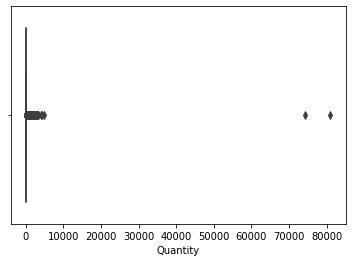

In [ ]:
sns.boxplot(df_na_treat['Quantity'])

In [ ]:
12+1.5*(12-2)

27.0

(-10.0, 80.0)

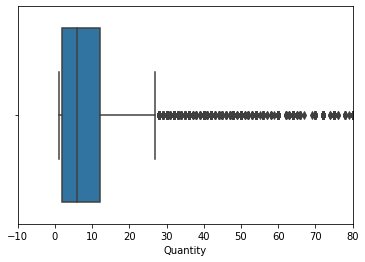

In [ ]:
sns.boxplot(df_na_treat['Quantity'])
plt.xlim(-10,80)

In [ ]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))

In [ ]:
outliers_iqr(df_na_treat['Quantity'])

(array([     9,     31,     44, ..., 397841, 397842, 397843], dtype=int64),)

In [ ]:
# 표준점수 기반 예제 코드
def std_based_outlier(df):
    for i in range(0, len(df.iloc[1])): 
        df.iloc[:,i] = df.iloc[:,i].replace(0, np.NaN) # optional
        df = df[~(np.abs(df.iloc[:,i] - df.iloc[:,i].mean()) > (3*df.iloc[:,i].std()))].fillna(0)

In [ ]:
# 2) 상위 1% 확인 
df_na_treat['Quantity'].quantile(0.99)

120.0

(-10.0, 150.0)

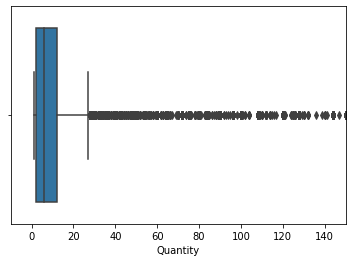

In [ ]:
sns.boxplot(df_na_treat['Quantity'])
plt.xlim(-10,150)

In [ ]:
# 3) 평균, 표준편차(더가면 평균부터 3시그마, 6시그마까지)
# >>> 분포그려보기

(-10.0, 150.0)

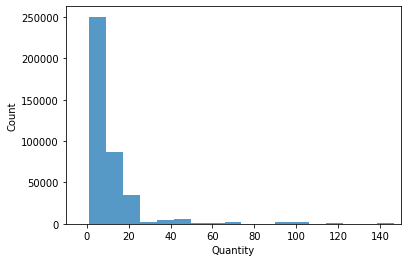

In [ ]:
sns.histplot(df_na_treat['Quantity'],bins = 10000)
plt.xlim(-10,150)

In [ ]:
import gc
gc.collect()

583168

In [ ]:
# https://lifelong-education-dr-kim.tistory.com/entry/python-pandas-series-type%EC%97%90%EC%84%9C-%EC%9D%B4%EC%83%81%EC%B9%98-outlier-%EC%A0%9C%EA%B1%B0-%ED%95%98%EA%B8%B0
q_mean = df_na_treat['Quantity'].mean()

In [ ]:
q_mean

12.988237777844798

In [ ]:
q_std =df_na_treat['Quantity'].std()

In [ ]:
q_std

179.33177496319874

In [ ]:
import scipy.stats as stats

In [ ]:
pdf = stats.norm.pdf(np.sort(df_na_treat['Quantity']), q_mean, q_std)

In [ ]:
pdf

array([0.24197072, 0.24197072, 0.24197072, ..., 0.        , 0.        ,
       0.        ])

In [ ]:
gc.collect()

12608

###[To-DO] Isolation으로 이상치 제거해보기  
https://minkithub.github.io/2020/05/03/seoulpark2/

##### Standard Scale    
(표준정규분포로의 표준화)  
: 평균은 0, 표준편차는 1이 되도록 변환해준다. 가장 일반적으로 사용되는 스케일링 기법

In [ ]:
from sklearn.preprocessing import StandardScaler

scale_data = df_na_treat[['Quantity']]

scaler = StandardScaler()
scaler.fit(scale_data)
scale_data_scaled_standard = scaler.transform(scale_data)
scale_data_scaled_standard_des = pd.DataFrame(scale_data_scaled_standard).describe()
scale_data_scaled_standard_des.columns = scale_data.columns
scale_data_scaled_standard_des = round(scale_data_scaled_standard_des)

In [ ]:
scale_data_scaled_standard #mean(0), std(1)확인 

,Quantity
count,397884.0
mean,0.0
std,1.0
min,-0.0
25%,-0.0
50%,-0.0
75%,-0.0
max,452.0


(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.3196e+05,
        5.3425e+04, 4.1840e+03, 4.4250e+03, 1.2660e+03, 4.9500e+02,
        5.6200e+02, 3.4300e+02, 2.6200e+02, 1.5600e+02, 7.2000e+01,
        1.0100e+02, 1.0800e+02, 1.1000e+01, 1.2300e+02]),
 array([-3.00000000e+00, -2.80000000e+00, -2.60000000e+00, -2.40000000e+00,
        -2.20000000e+00, -2.00000000e+00, -1.80000000e+00, -1.60000000e+00,
        -1.40000000e+00, -1.20000000e+00, -1.00000000e+00, -8.00000000e-01,
        -6.00000000e-01, -4.00000000e-01, -2.00000000e-01,  2.66453526e-15,
         2.00000000e-01,  4.00000000e-01,  6.00000000e-01,  8.00000000e-01,
         1.00000000e+00,  1.20000000e+00,  1.40000000e+00,  1.60000000e+00,
         1.80000000e+00,  2.00000000e+00,  2.20000000e+00,  2.40000000e+00,
         2.60000000e+00,  2.80000000e+00]),
 <BarContainer object of 2

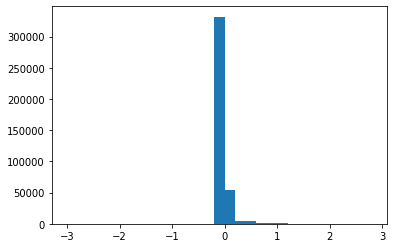

In [ ]:
plt.hist(scale_data_scaled_standard, bins = np.arange(-3,3,0.2))

In [ ]:
zoom_in_standard = scale_data_scaled_standard[scale_data_scaled_standard<1*3]

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.3196e+05,
        5.3425e+04, 4.1840e+03, 4.4250e+03, 1.2660e+03, 4.9500e+02,
        5.6200e+02, 3.4300e+02, 2.6200e+02, 1.5600e+02, 7.2000e+01,
        1.0100e+02, 1.0800e+02, 1.1000e+01, 1.2300e+02]),
 array([-3.00000000e+00, -2.80000000e+00, -2.60000000e+00, -2.40000000e+00,
        -2.20000000e+00, -2.00000000e+00, -1.80000000e+00, -1.60000000e+00,
        -1.40000000e+00, -1.20000000e+00, -1.00000000e+00, -8.00000000e-01,
        -6.00000000e-01, -4.00000000e-01, -2.00000000e-01,  2.66453526e-15,
         2.00000000e-01,  4.00000000e-01,  6.00000000e-01,  8.00000000e-01,
         1.00000000e+00,  1.20000000e+00,  1.40000000e+00,  1.60000000e+00,
         1.80000000e+00,  2.00000000e+00,  2.20000000e+00,  2.40000000e+00,
         2.60000000e+00,  2.80000000e+00]),
 <BarContainer object of 2

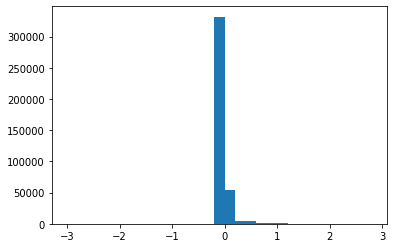

In [ ]:
plt.hist(zoom_in_standard, bins = np.arange(-3,3,0.2))

#### 표준편차가 3 /-3 범위 밖에있는 데이터를 outlier로 간주

In [ ]:
scaler.inverse_transform(np.array([[-3]]))[0][0]

-525.0064110407573

In [ ]:
# 원래값의 outlier임계값찾기
scaler.inverse_transform(np.array([[3]]))[0][0]

550.9828865964469

In [ ]:
df_na_treat[df_na_treat.Quantity > 550].shape

(388, 9)

In [ ]:
df_na_treat[df_na_treat.Quantity > 550]['Quantity'].describe()

count      388.000000
mean      1344.860825
std       5531.335671
min        552.000000
25%        600.000000
50%        720.000000
75%       1072.000000
max      80995.000000
Name: Quantity, dtype: float64

In [ ]:
df_na_treat[['Quantity']]

,Quantity
0,6
1,6
2,8
3,6
4,6
...,...
397879,12
397880,6
397881,4
397882,4


#### RobustScale   
: 중앙값(median) 0, IQR(interquartile range)이 1이 되도록 변환해준다. Roubust Scale은 이상치의 영향을 최소화한 기법으로 Standard Scale보다 표준화 값을 더 넓게 분포시킨다는 특징이 있다.

In [ ]:
len(df_na_treat.Quantity)

397884

In [ ]:
df_na_treat[['Quantity']]

,Quantity
0,6
1,6
2,8
3,6
4,6
...,...
397879,12
397880,6
397881,4
397882,4


In [ ]:
from sklearn.preprocessing import RobustScaler

scale_data = df_na_treat[['Quantity']]

robust_scaler = RobustScaler()
robust_scaler.fit(scale_data)
scale_data_scaled_robust = robust_scaler.transform(scale_data)
scale_data_scaled_robust_des = pd.DataFrame(scale_data_scaled_robust).describe()
scale_data_scaled_robust_des.columns = scale_data.columns
scale_data_scaled_robust_des = round(scale_data_scaled_robust_des)

In [ ]:
df_na_treat.shape

(397884, 9)

In [ ]:
len(scale_data_scaled_robust)

397884

In [ ]:
df_na_treat[['Quantity']].quantile(0.75)-df_na_treat[['Quantity']].quantile(0.25)

Quantity    10.0
dtype: float64

In [ ]:
scale_data_scaled_robust_des #mean, std확인 (IQR)

,Quantity
count,397884.0
mean,1.0
std,18.0
min,-0.0
25%,-0.0
50%,0.0
75%,1.0
max,8099.0


In [ ]:
zoom_in_robust = scale_data_scaled_robust[scale_data_scaled_robust<18*3]

In [ ]:
scale_data_scaled_robust

array([[ 0. ],
       [ 0. ],
       [ 0.2],
       ...,
       [-0.2],
       [-0.2],
       [-0.3]])

In [ ]:
zoom_in_robust

array([ 0. ,  0. ,  0.2, ..., -0.2, -0.2, -0.3])

In [ ]:
# 원래값의 outlier임계값찾기
# X_origin = robust_scaler.inverse_transform(X_train_scaled)
# 3 * std
robust_scaler.inverse_transform(np.array([[18*3]]))[0][0]

546.0

In [ ]:
# 원래값의 outlier임계값찾기
robust_scaler.inverse_transform(np.array([[18]]))[0][0]

186.0

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.98576e+05,
        1.73578e+05, 7.22900e+03, 7.90500e+03, 2.28400e+03, 3.66000e+03,
        7.81000e+02, 1.17100e+03, 1.66000e+02, 6.80000e+01]),
 array([-20, -18, -16, -14, -12, -10,  -8,  -6,  -4,  -2,   0,   2,   4,
          6,   8,  10,  12,  14,  16,  18]),
 <BarContainer object of 19 artists>)

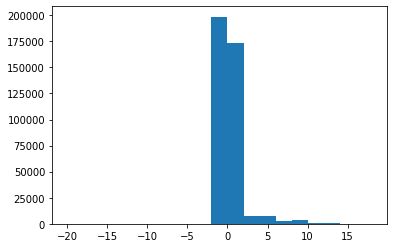

In [ ]:
plt.hist(scale_data_scaled_robust, bins = np.arange(-20,20,2))

In [ ]:
len(scale_data_scaled_robust) - len(zoom_in_robust)

388

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.98576e+05,
        1.73578e+05, 7.22900e+03, 7.90500e+03, 2.28400e+03, 3.66000e+03,
        7.81000e+02, 1.17100e+03, 1.66000e+02, 6.80000e+01]),
 array([-20, -18, -16, -14, -12, -10,  -8,  -6,  -4,  -2,   0,   2,   4,
          6,   8,  10,  12,  14,  16,  18]),
 <BarContainer object of 19 artists>)

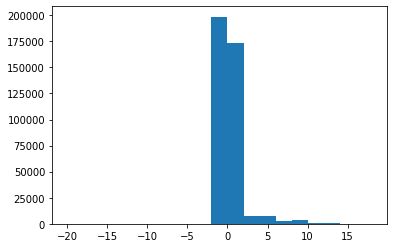

In [ ]:
plt.hist(zoom_in_robust, bins = np.arange(-20,20,2))